In [ ]:
import custom_system_properties as csp

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import discretisedfield as df
import micromagneticmodel as mm
import micromagneticdata as md

In [ ]:
import oommfc as oc

## Main parameters

In [77]:
system = mm.System(name='breaking2022macedo')

system_prop = csp.SystemProperties(lx=120e-9, ly=120e-9, lz=10e-9)
system_prop.cell = (5e-9, 5e-9, 5e-9)
system_prop.units = ('m', 'm', 'm')
#system_prop.update_lengths()
system_prop.update_numcells()

In [78]:
system_prop

SystemProperties(lx=1.2e-07, ly=1.2e-07, lz=1e-08, cell=(5e-09, 5e-09, 5e-09), p1=(0, 0, 0), units=('m', 'm', 'm'), p2=(1.2e-07, 1.2e-07, 1e-08), numcells=(23, 23, 2))

In [79]:
# Saturisation magnetisation
Ms = 8e5  # kA/m

# exchange stiffness
A = 1.3e-11 # (43.5 * Ms * system_prop.cell[0])/2

# External static Zeeman field strength
H = 8e4 * np.array([0.81345856316858023, 0.58162287266553481, 0.0])
#H0 = tuple(x/mm.consts.mu0 for x in [0, 0, 0.1])  # A/m

# External dynamic Zeeman field strength
h0 = tuple(x/mm.consts.mu0 for x in [3e-3, 0, 0])  # A/m

# Driving frequency
f = 42.5e9  # Hz

# Stepsize at which equations are evaluated
h = 1e-15  # s

# Gilbert damping
alpha = 0.008

gamma0 = 2.211e5

## Regions

In [80]:
%%capture
system_region = csp.MyRegions(system.name + "_regions")

system_region.main(p1=system_prop.p1, p2=system_prop.p2, 
                   dims=('x', 'y', 'z'), units=system_prop.units)

In [ ]:
%%capture
system_subregions = csp.MyRegions(system.name + "_subregions")

system_subregions.fixedLhs(p1=system_region.main.p1, 
                           p2=system_prop.cell, 
                           dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.driven(p1=csp.add_tuples(system_subregions.fixedLhs.p2, 
                                       dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.fixedLhs.p2, system_prop.cell, 
                                       mult=5, dims='x'), 
                         dims=('x', 'y', 'z'), units=system_prop.units)
system_subregions.free(p1=csp.add_tuples(system_subregions.driven.p2, 
                                       dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.driven.p2, system_prop.cell, mult=95, dims='x'), 
                         dims=('x', 'y', 'z'), units=system_prop.units)
system_subregions.fixedRhs(p1=csp.add_tuples(system_region.main.p2, system_prop.cell, 
                                         mult=-1, dims='x', base=system_prop.p1),
                           p2=system_region.main.p2, 
                           dims=('x', 'y', 'z'), units=system_prop.units)

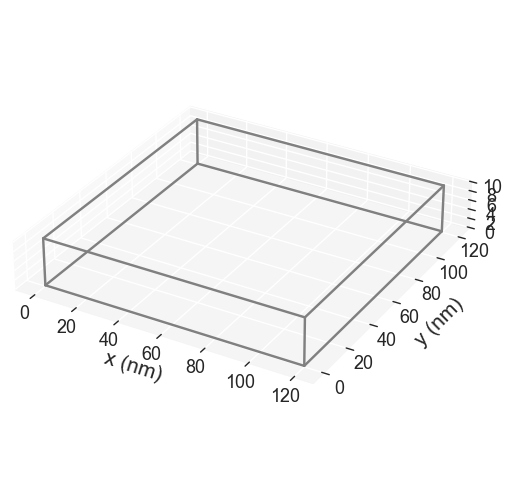

In [81]:
system_region._mesh = df.Mesh(region=system_region.main.region, 
                              cell=system_prop.cell)
                              #subregions=system_subregions.regions)

system_region._mesh.mpl.subregions(figsize=(8, 6), multiplier=1e-9,box_aspect=(6,6,1), show_region=True)

### Energy equations

In [ ]:
system_subregions.driven.region

In [ ]:
def h0_func(pos):
    if pos in system_subregions.driven.region:
        return h0
    else:
        return (0, 0, 0)
    #x, y, z = pos
    
    #if system_subregions.driven.p1[0] <= x < system_subregions.driven.p2[0]:
    #    return h0
    #else:
    #    return (0,0,0)

In [ ]:
# system_subregions.driven.mesh = df.Mesh(region=system_region.main.region, cell=system_prop.cell)

In [ ]:
h0_field = df.Field(mesh=system_region._mesh, nvdim=3, value=h0_func)
#region_values = {"region1": (1, 1, 1), "region2": (2, 2, 2)}
#h0_field.update_field_values(region_values)

In [82]:
#system.energy = mm.Zeeman(H=H0, name='static') + mm.Exchange(A=A)
system.energy = mm.Zeeman(H=H) + mm.Exchange(A=A) + mm.Demag()

### dynamics

In [83]:
system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha)

In [ ]:
mag_vals = system_subregions.mag_vals
mag_vals['fixedLhs'] = (0, 0, 1)
mag_vals['fixedRhs'] = (0, 0, 1)
mag_vals

In [84]:
#system.m = df.Field(mesh=system_region._mesh, nvdim=3, value=mag_vals, norm=Ms)
system.m = df.Field(mesh=system_region._mesh, nvdim=3, value=(0,0,1), norm=Ms)

### Relaxation

In [85]:
minD = oc.MinDriver()
minD.drive(system, verbose=2)  # fixed_subregions=['fixedLhs', 'fixedRhs']

Running OOMMF (TclOOMMFRunner)[2024/05/27 17:16]... (0.7 s)


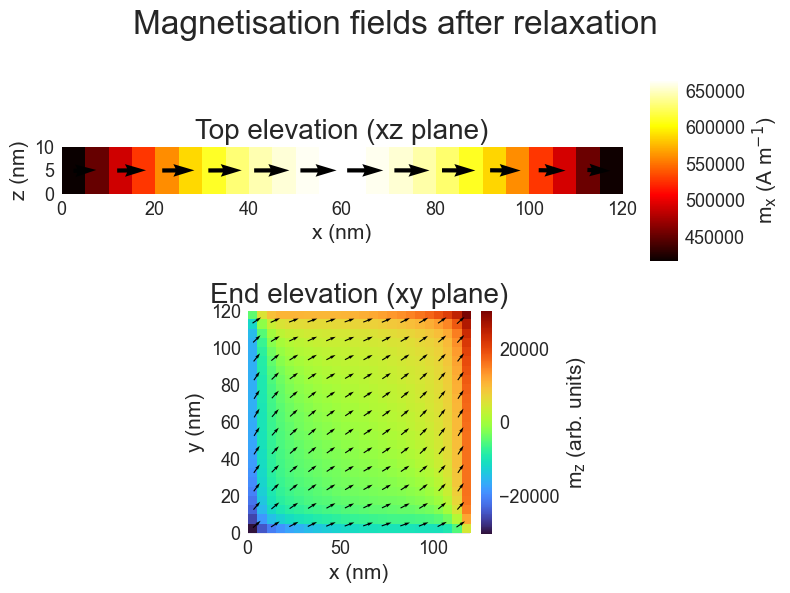

In [86]:
fig1, fig1_axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
fig1.suptitle('Magnetisation fields after relaxation', fontsize=24)

system.m.sel('y').resample((24, 2)).x.mpl.scalar(ax=fig1_axs[0], cmap='hot', colorbar_label='m$_\\text{x}$ (A m$^{-1}$)')
system.m.sel('y').resample((12, 1)).mpl.vector(ax=fig1_axs[0], 
                                               vdims=['x', 'z'],
                                               color_field=system.m.z.sel("y"),
                                               use_color=False,
                                               colorbar=False)
fig1_axs[0].set(title='Top elevation (xz plane)', aspect=1)

system.m.sel('z').resample((24, 24)).z.mpl.scalar(ax=fig1_axs[1], cmap='turbo', colorbar_label='m$_\\text{z}$ (arb. units)')
system.m.sel('z').resample((12, 12)).mpl.vector(ax=fig1_axs[1], 
                                               vdims=['x', 'y'],
                                               color='black',
                                               use_color=False)

fig1_axs[1].set(title='End elevation (xy plane)', aspect=1)


fig1.tight_layout()

In [ ]:
#m = system.m.orientation

### Time-dependent field

In [87]:
system.energy

Zeeman(H=[65076.68505349 46529.82981324     0.        ]) + Exchange(A=1.3e-11) + Demag()

In [88]:
H = 8e4 * np.array([0.81923192051904048, 0.57346234436332832, 0.0])
system.energy.zeeman.H = H

In [ ]:
system.energy += mm.Zeeman(H=h0_field, name='pump', func='sin',f=f, t0=0,dt=1e-13)

In [ ]:
sim_evolver = oc.RungeKuttaEvolver(method='rk2',
                                          do_precess=1,
                                          allow_signed_gamma=0,
                                          max_timestep=h,
                                          )

In [89]:

td = oc.TimeDriver()#evolver=sim_evolver)

In [90]:
td.drive(system, t=20e-9, n=4000, verbose=2)

Running OOMMF (TclOOMMFRunner):   0%|          | 0/4000 files written [00:00]

Running OOMMF (TclOOMMFRunner)[2024/05/27 17:17] took 43.3 s


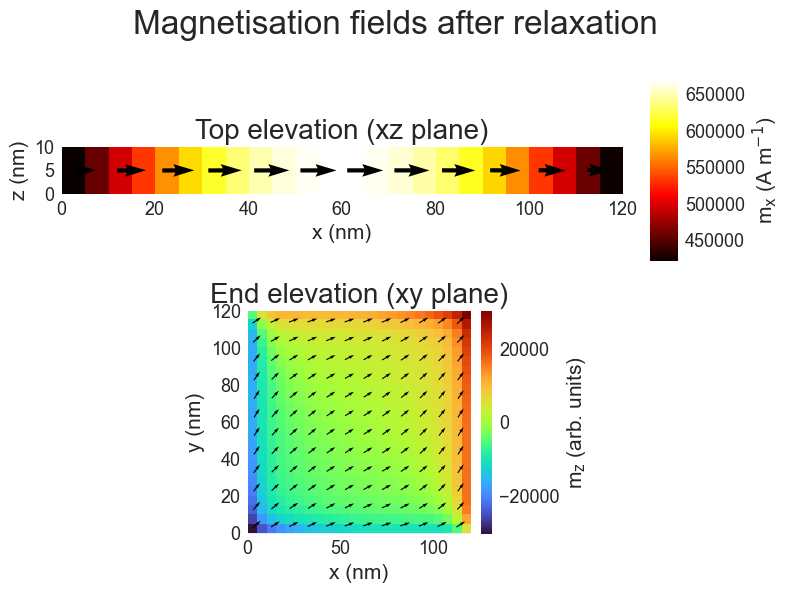

In [92]:
fig2, fig2_axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
fig2.suptitle('Magnetisation fields after relaxation', fontsize=24)

system.m.sel('y').resample((24, 2)).x.mpl.scalar(ax=fig2_axs[0], cmap='hot', colorbar_label='m$_\\text{x}$ (A m$^{-1}$)')
system.m.sel('y').resample((12, 1)).mpl.vector(ax=fig2_axs[0], 
                                               vdims=['x', 'z'],
                                               color_field=system.m.z.sel("y"),
                                               use_color=False,
                                               colorbar=False)
fig2_axs[0].set(title='Top elevation (xz plane)', aspect=1)

system.m.sel('z').resample((24, 24)).z.mpl.scalar(ax=fig2_axs[1], cmap='turbo', colorbar_label='m$_\\text{z}$ (arb. units)')
system.m.sel('z').resample((12, 12)).mpl.vector(ax=fig2_axs[1], 
                                               vdims=['x', 'y'],
                                               color='black',
                                               use_color=False)

fig2_axs[1].set(title='End elevation (xy plane)', aspect=1)


fig2.tight_layout()

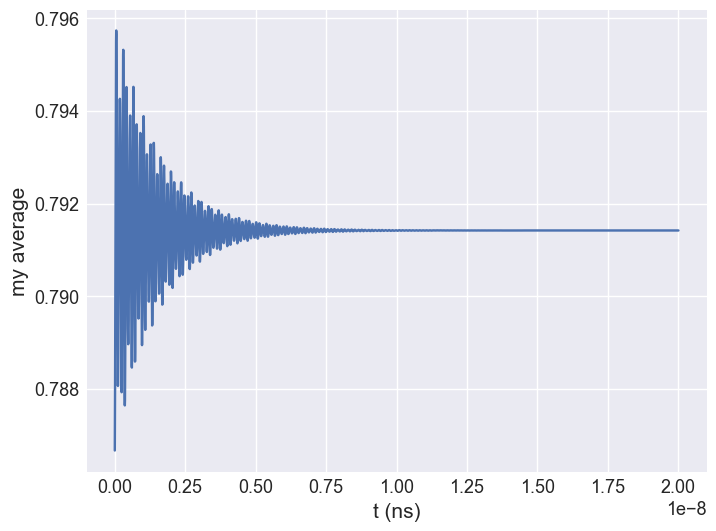

In [91]:
t = system.table.data['t'].values
my = system.table.data['mx'].values

# Plot <my> time evolution.
plt.figure(figsize=(8, 6))
plt.plot(t, my)
plt.xlabel('t (ns)')
plt.ylabel('my average')
plt.grid()

In [ ]:
fig2, (fig2_ax1, fig2_ax2, fig2_ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20, 5))
fig2.suptitle('Magnetisation fields after relaxation (y-plane)', fontsize=24)

# plot vectors on grid of 20 x 5 over the numerical resulotion
system.m.x.sel("y").mpl(ax=fig2_ax1, scalar_kw={"colorbar_label": "m$_\\text{x}$ (A m$^{-1}$)"})
fig2_ax1.set(aspect=200)

system.m.y.sel('y').mpl(ax=fig2_ax2, scalar_kw={"colorbar_label": "m$_\\text{y}$ (A m$^{-1}$)"})
fig2_ax2.set(aspect=200)

system.m.z.sel('y').mpl(ax=fig2_ax3, scalar_kw={"colorbar_label": "m$_\\text{z}$ (A m$^{-1}$)"})
fig2_ax3.set(aspect=200)

In [ ]:
data = md.Data(system.name)
# Use only the last time drive
time_drive = data[-1]

time_drive.hv(
    kdims=["x", "y"],
    scalar_kw={"clim": (-Ms, Ms), "cmap": "coolwarm"},
)